In [20]:
# import os, numpy as np, pandas as pd
# from datasets import Dataset, DatasetDict
# from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
# from sklearn.preprocessing import LabelEncoder

# # 0) Optional: redirect HF cache if C: is low on space (uncomment and adjust)
# # os.environ["HF_HOME"] = "D:/hf_cache"
# # os.environ["TRANSFORMERS_CACHE"] = "D:/hf_cache/models"

# # 1) Load processed parquet
# train = pd.read_parquet("../data/processed/classification_train.parquet")
# val   = pd.read_parquet("../data/processed/classification_val.parquet")
# test  = pd.read_parquet("../data/processed/classification_test.parquet")

# print("Train",train)
# print("Validation",val)
# print("Testing",test)

# # 2) Encode labels
# le = LabelEncoder()
# train["label_id"] = le.fit_transform(train["label"])
# val["label_id"]   = le.transform(val["label"])
# test["label_id"]  = le.transform(test["label"])

# # 3) Build HF datasets from pandas
# ds = DatasetDict({
#     "train": Dataset.from_pandas(train[["text", "label_id"]].rename(columns={"text": "text"})),
#     "validation": Dataset.from_pandas(val[["text", "label_id"]].rename(columns={"text": "text"})),
#     "test": Dataset.from_pandas(test[["text", "label_id"]].rename(columns={"text": "text"})),
# })

# # 4) (Optional) Subsample per split for speed on CPU
# MAX_TRAIN = 4000  # set None to use full
# MAX_VAL   = 800
# MAX_TEST  = 1500
# def cap_split(dset, cap):
#     if cap is None or cap >= len(dset):
#         return dset
#     dset = dset.shuffle(seed=42)
#     return dset.select(range(cap))

# ds["train"] = cap_split(ds["train"], MAX_TRAIN)
# ds["validation"] = cap_split(ds["validation"], MAX_VAL)
# ds["test"] = cap_split(ds["test"], MAX_TEST)

# # 5) Choose a smaller model (fast on CPU)
# # Options:
# #   model_name = "prajjwal1/bert-tiny"         # very fast, minimal
# #   model_name = "distilbert/distilbert-base-uncased"  # small & strong baseline
# model_name = "prajjwal1/bert-tiny"

# tok = AutoTokenizer.from_pretrained(model_name)

# # 6) Tokenize with shorter sequences for speed
# MAX_LEN = 128
# def tokenize(batch):
#     return tok(batch["text"], truncation=True, padding="max_length", max_length=MAX_LEN)

# ds_tok = ds.map(tokenize, batched=True, desc="Tokenizing")
# ds_tok = ds_tok.rename_column("label_id", "labels")
# ds_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# # 7) Model
# num_labels = len(le.classes_)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# # 8) Training args tuned for CPU speed
# args = TrainingArguments(
#     output_dir="artifacts/bert_resume_cls_fast",
#     evaluation_strategy="epoch",
#     save_strategy="no",              # avoid checkpoint overhead
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,  # increase if RAM allows; lower if OOM
#     per_device_eval_batch_size=32,
#     num_train_epochs=1,              # 1 epoch for quick run
#     weight_decay=0.0,
#     logging_steps=50,
#     report_to="none",                # disable W&B, etc.
# )

# trainer = Trainer(
#     model=model,
#     args=args,
#     train_dataset=ds_tok["train"],
#     eval_dataset=ds_tok["validation"],
#     tokenizer=tok,
# )

# trainer.train()
# trainer.evaluate(ds_tok["test"])

import os, numpy as np, pandas as pd, torch
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder

# 0) Optional: redirect HF cache if C: is low on space
# os.environ["HF_HOME"] = "D:/hf_cache"; os.environ["TRANSFORMERS_CACHE"] = "D:/hf_cache/models"

# 1) Load processed parquet
train = pd.read_parquet("../data/processed/classification_train.parquet")
val   = pd.read_parquet("../data/processed/classification_val.parquet")
test  = pd.read_parquet("../data/processed/classification_test.parquet")

# 2) Encode labels
le = LabelEncoder()
train["label_id"] = le.fit_transform(train["label"])
val["label_id"]   = le.transform(val["label"])
test["label_id"]  = le.transform(test["label"])

# 3) Build HF datasets from pandas
ds = DatasetDict({
    "train": Dataset.from_pandas(train[["text", "label_id"]].rename(columns={"text": "text"})),
    "validation": Dataset.from_pandas(val[["text", "label_id"]].rename(columns={"text": "text"})),
    "test": Dataset.from_pandas(test[["text", "label_id"]].rename(columns={"text": "text"})),
})
# Fix a typo if it appears:
if "text," in ds["test"].column_names:
    ds["test"] = ds["test"].rename_columns({"text,":"text"})

# 4) Subsample caps (tune for speed vs accuracy)
MAX_TRAIN = None   # None -> use full; set 6000 for medium; 2000 for quick
MAX_VAL   = None
MAX_TEST  = None
def cap_split(dset, cap):
    if cap is None or cap >= len(dset): return dset
    return dset.shuffle(seed=42).select(range(cap))
ds["train"] = cap_split(ds["train"], MAX_TRAIN)
ds["validation"] = cap_split(ds["validation"], MAX_VAL)
ds["test"] = cap_split(ds["test"], MAX_TEST)

# 5) Model/tokenizer: DistilBERT (compact but stronger than bert-tiny)
model_name = "distilbert/distilbert-base-uncased"
tok = AutoTokenizer.from_pretrained(model_name)

# 6) Tokenize with longer sequences
MAX_LEN = 256
def tokenize(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=MAX_LEN)
ds_tok = ds.map(tokenize, batched=True, desc="Tokenizing")
ds_tok = ds_tok.rename_column("label_id", "labels")
ds_tok.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

# 7) Model
num_labels = len(le.classes_)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# 7a) Class weights from train labels (inverse frequency)
lbls = np.array(ds_tok["train"]["labels"])
counts = np.bincount(lbls, minlength=num_labels).astype(np.float32)
weights = (counts.sum() / (num_labels * np.maximum(counts, 1.0))).astype(np.float32)
class_weights = torch.tensor(weights)

# 7b) Custom Trainer to apply weighted CE loss
import torch.nn as nn
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**{k:v for k,v in inputs.items() if k!="labels"})
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# 8) Training args for better accuracy (still CPU-safe)
args = TrainingArguments(
    output_dir="artifacts/distilbert_resume_cls",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=8,    # keep modest on CPU
    per_device_eval_batch_size=16,
    num_train_epochs=3,               # increase to 4–5 if time allows
    weight_decay=0.01,
    warmup_ratio=0.1,                 # small warmup helps stability
    logging_steps=50,
    report_to="none",
)

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=ds_tok["train"],
    eval_dataset=ds_tok["validation"],
    tokenizer=tok,
)

trainer.train()
metrics = trainer.evaluate(ds_tok["test"])
metrics



tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Tokenizing:   0%|          | 0/9372 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/1339 [00:00<?, ? examples/s]

Tokenizing:   0%|          | 0/2678 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.841800,0.707565
2,0.598600,0.602166
3,0.359300,0.572640


{'eval_loss': 0.5607104301452637,
 'eval_runtime': 376.3872,
 'eval_samples_per_second': 7.115,
 'eval_steps_per_second': 0.446,
 'epoch': 3.0}

## Label space and class counts

In [21]:
import pandas as pd
from collections import Counter

# Original splits (pandas)
train_df = pd.read_parquet("../data/processed/classification_train.parquet")
val_df   = pd.read_parquet("../data/processed/classification_val.parquet")
test_df  = pd.read_parquet("../data/processed/classification_test.parquet")

# Top-15 labels in train
train_counts = pd.Series(Counter(train_df['label'])).sort_values(ascending=False).head(15).reset_index()
train_counts.columns = ['label','count']
train_counts

,label,count
0,Education,287
1,Mechanical Engineer,269
2,Electrical Engineering,269
3,Consultant,257
4,Civil Engineer,255
5,Sales,255
6,Management,253
7,Human Resources,252
8,Digital Media,251
9,Accountant,245


## Sample DataFrame for Training, Validation and Testing

In [22]:
def peek(df, n=5):
    return df[['text','label']].sample(n, random_state=42).reset_index(drop=True)

print("Training Data")
display(peek(train_df))
print("Validation Data")
display(peek(val_df))
print("Testing Data")
display(peek(test_df))

Training Data


,text,label
0,jessica claire montgomery street san francisco...,Arts
1,joseph mcleod electrical engineer eit certifie...,Electrical Engineering
2,carla jensen apparel designer 323 triflingsick...,Apparel
3,camren jacobs art instructor saugus [PHONE] ca...,Arts
4,professional summary jessica claire 100 montgo...,Banking


Validation Data


,text,label
0,angela lopez sr marketing consultant contact 1...,Consultant
1,entry level java developer reports development...,Java Developer
2,avery rodriguez entry level net developer c as...,DotNet Developer
3,jessica claire 9 resumesampleexamplecom [PHONE...,SQL Developer
4,jessica claire montgomery street san francisco...,Information Technology


Testing Data


,text,label
0,leo schuster 7020 kling lakes los angeles ca p...,Agriculture
1,jessica claire resumesampleexamplecom [PHONE] ...,Accountant
2,professional summary technical skills work his...,DevOps
3,summary jessica claire 100 montgomery st 10th ...,Network Security Engineer
4,jessica claire 100 montgomery st 10th floor [P...,Education


## Predicted Dataframes 

In [23]:
import torch
from torch.nn.functional import softmax

small = ds_tok['test'].select(range(50))
with torch.no_grad():
    logits = model(**{k: small[k] for k in ['input_ids','attention_mask']}).logits
probs = softmax(logits, dim=1).cpu().numpy()
pred_ids = probs.argmax(axis=1)

id2label = {i: l for i, l in enumerate(le.classes_)}
pred_labels = [id2label[i] for i in pred_ids]
true_labels = [id2label[int(i)] for i in small['labels']]  # cast tensor -> int

pred_df = pd.DataFrame({
    'text': small['text'],
    'true_label': true_labels,
    'pred_label': pred_labels,
    'confidence': probs.max(axis=1).round(4)
})
pred_df.head(10)


,text,true_label,pred_label,confidence
0,sample accountant resume lovetoknow advice tru...,Accountant,Accountant,0.9908
1,maximo nores address 3400 sampson street los a...,Digital Media,Digital Media,0.9869
2,beanna sharafi customer advocate beannasharafi...,Advocate,Advocate,0.9905
3,areas expertise business development operation...,Management,Management,0.9808
4,jessica claire 100 montgomery st 10th floor [P...,Mechanical Engineer,Mechanical Engineer,0.9922
5,jessica claire montgomery street san francisco...,Management,Management,0.9816
6,jessica claire montgomery street san francisco...,Health and Fitness,Advocate,0.9897
7,jessica claire montgomery street san francisco...,Mechanical Engineer,Mechanical Engineer,0.9914
8,jessica claire montgomery street san francisco...,Consultant,Management,0.8262
9,jessica claire resumesampleexamplecom [PHONE] ...,Business Analyst,Business Analyst,0.9861


In [12]:
pip install matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----------- ---------------------------- 2.4/8.1 MB 11.2 MB/s eta 0:00:01
   ----------------------- ---------------- 4.7/8.1 MB 11.4 MB/s eta 0:00:01
   ---------------------------------- ----- 7.1/8.1 MB 11.5 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 11.2 MB/s  0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 10.7 MB/s  0:00:00

   ---------------------------------------- 0/6 [pyparsing]
   ---------------------------------------- 0/6 [pyparsing]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
   ------------- -------------------------- 2/6 [fonttools]
  

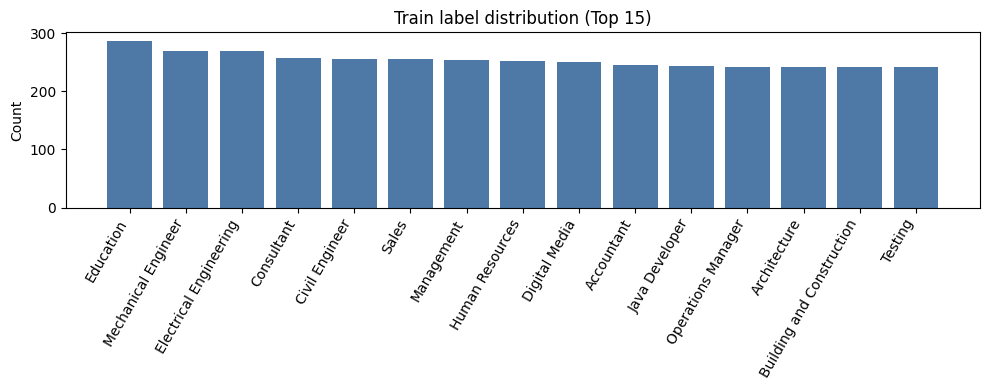

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.bar(train_counts['label'], train_counts['count'], color='#4e79a7')
plt.xticks(rotation=60, ha='right')
plt.ylabel('Count')
plt.title('Train label distribution (Top 15)')
plt.tight_layout()
plt.show()


## Confusion Matrix Display

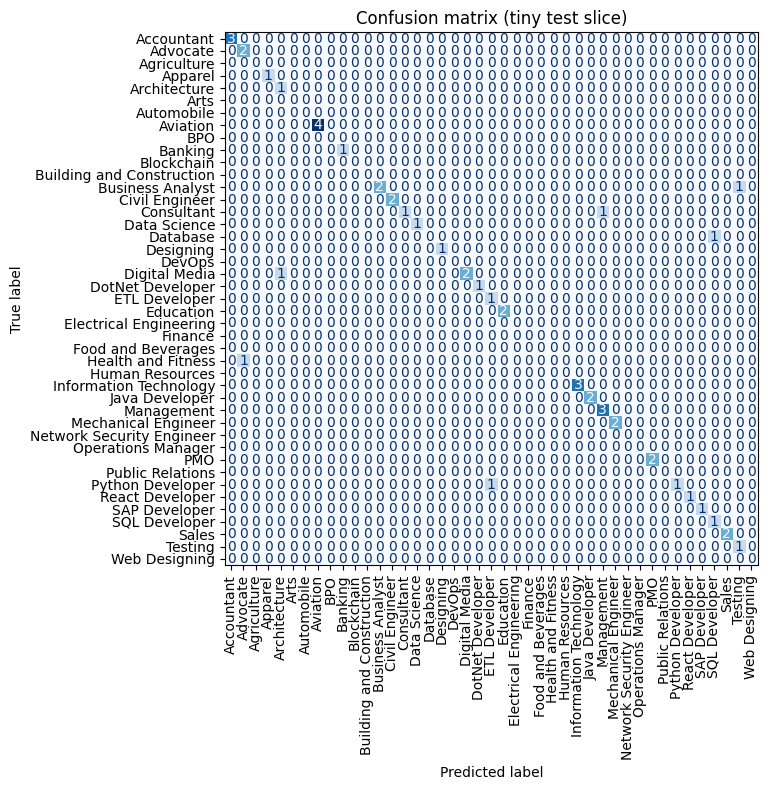

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Use the same small slice as above
cm = confusion_matrix(true_labels, pred_labels, labels=le.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=90, colorbar=False)
ax.set_title('Confusion matrix (tiny test slice)')
plt.tight_layout()
plt.show()


## Classification Report 

In [26]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, pred_labels, labels=le.classes_, zero_division=0))

                           precision    recall  f1-score   support

               Accountant       1.00      1.00      1.00         3
                 Advocate       0.67      1.00      0.80         2
              Agriculture       0.00      0.00      0.00         0
                  Apparel       1.00      1.00      1.00         1
             Architecture       0.50      1.00      0.67         1
                     Arts       0.00      0.00      0.00         0
               Automobile       0.00      0.00      0.00         0
                 Aviation       1.00      1.00      1.00         4
                      BPO       0.00      0.00      0.00         0
                  Banking       1.00      1.00      1.00         1
               Blockchain       0.00      0.00      0.00         0
Building and Construction       0.00      0.00      0.00         0
         Business Analyst       1.00      0.67      0.80         3
           Civil Engineer       1.00      1.00      1.00     

In [27]:
from sklearn.metrics import accuracy_score
print(accuracy_score(true_labels,pred_labels))

0.88
